In [ ]:
## Mini project 4 - History Kaggle Demo: Allstate Claims

#### This Week's Topic：Allstate Claims Severity

You can get the detailed information and download the data from the following link:<br/>
https://www.kaggle.com/c/allstate-claims-severity

Note: You need to sign up a Kaggle Account before you can download the data.

In [ ]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
## Type your answers here ##
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing, cross_validation
import time
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Load data

In [4]:
train = pd.read_csv('Desktop/DAL/train.csv', header=0)
test = pd.read_csv('Desktop/DAL/test.csv', header=0)
train_size = train.shape[0]
test_size = test.shape[0]

# Merge Train and Test

In [5]:
full_data = pd.concat([train,test]).reset_index(drop=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
full_data.head()

C:\Users\WZHANG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat5,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat6,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cont1,cont10,cont11,cont12,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,id,loss
0,A,A,B,G,A,A,I,E,G,J,G,BU,B,BC,C,AS,S,A,O,LB,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,A,D,D,B,D,C,B,D,B,A,A,B,A,A,A,D,B,C,E,A,C,T,0.726300,0.83510,0.569745,0.594646,0.822493,0.714843,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,1,2213.18
1,A,B,L,F,A,A,E,E,I,K,K,BI,A,CQ,A,AV,BM,A,O,DP,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,D,D,A,B,C,B,D,B,A,A,B,A,A,A,D,D,C,E,E,D,T,0.330514,0.43919,0.338312,0.366307,0.611431,0.304496,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,2,1283.60
2,A,B,L,O,A,B,E,F,H,F,A,AB,B,DK,A,C,AF,A,I,GK,B,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,B,D,B,D,C,B,B,B,A,A,B,A,A,A,D,D,C,E,E,A,D,0.261841,0.32446,0.381398,0.373424,0.195709,0.774425,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,5,3005.09
3,B,A,I,D,A,A,E,E,I,K,K,BI,A,CS,C,N,AE,A,O,DJ,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,A,D,D,D,B,C,B,D,B,A,A,B,A,A,A,D,D,C,E,E,D,T,0.321594,0.44467,0.327915,0.321570,0.605077,0.602642,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,10,939.85
4,A,B,F,J,A,A,D,E,K,G,B,H,A,C,C,Y,BM,A,K,CK,B,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,A,B,D,B,B,C,B,B,C,A,A,B,A,B,H,D,B,D,E,E,A,P,0.273204,0.21230,0.204687,0.202213,0.246011,0.432606,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,11,2763.85


# Group Features

In [6]:
data_types = full_data.dtypes

cat_cols = list(data_types[data_types=='object'].index)
con_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

In [7]:
id_col='id'
target_col ='loss'

con_cols.remove('id')
con_cols.remove('loss')

In [8]:
print(train.shape)
print(test.shape)
print(full_data.shape)
print('\n')
print ("Categorical features:", cat_cols)
print('cat_cols:', len(cat_cols))
print('\n')
print ( "Numerica features:", con_cols)
print('con_cols:', len(con_cols))

(188318, 132)
(125546, 131)
(313864, 132)


Categorical features: ['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat11', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat2', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat3', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat4', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat5', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat6', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat7', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat8', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87

In [9]:
train.isnull().sum()

id        0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cat19     0
cat20     0
cat21     0
cat22     0
cat23     0
cat24     0
cat25     0
cat26     0
cat27     0
cat28     0
cat29     0
cat30     0
cat31     0
cat32     0
cat33     0
cat34     0
cat35     0
cat36     0
cat37     0
cat38     0
cat39     0
cat40     0
cat41     0
cat42     0
cat43     0
cat44     0
cat45     0
cat46     0
cat47     0
cat48     0
cat49     0
cat50     0
cat51     0
cat52     0
cat53     0
cat54     0
cat55     0
cat56     0
cat57     0
cat58     0
cat59     0
cat60     0
cat61     0
cat62     0
cat63     0
cat64     0
cat65     0
cat66     0
cat67     0
cat68     0
cat69     0
cat70     0
cat71     0
cat72     0
cat73     0
cat74     0
cat75     0
cat76     0
cat77     0
cat78     0
cat79     0
cat80     0
cat81     0
cat82     0
cat8

In [10]:
print(train.describe())

                  id          cont1          cont2          cont3  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean   294135.982561       0.493861       0.507188       0.498918   
std    169336.084867       0.187640       0.207202       0.202105   
min         1.000000       0.000016       0.001149       0.002634   
25%    147748.250000       0.346090       0.358319       0.336963   
50%    294539.500000       0.475784       0.555782       0.527991   
75%    440680.500000       0.623912       0.681761       0.634224   
max    587633.000000       0.984975       0.862654       0.944251   

               cont4          cont5          cont6          cont7  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.491812       0.487428       0.490945       0.484970   
std         0.211292       0.209027       0.205273       0.178450   
min         0.176921       0.281143       0.012683       0.069503   
25%         0.327354       0.2811

# Data Visulization

C:\Users\WZHANG\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


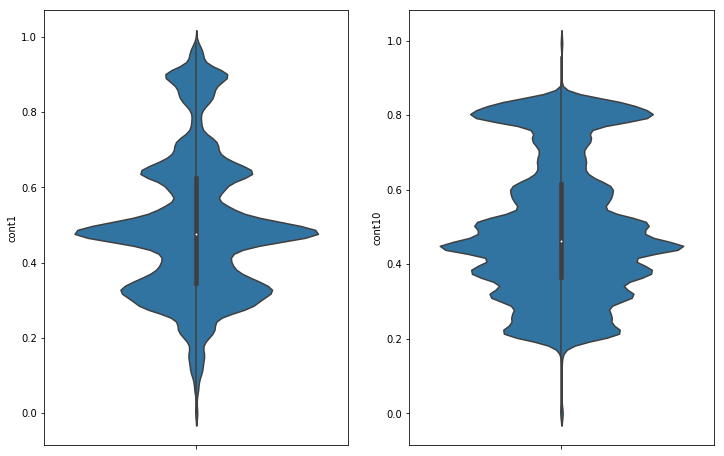

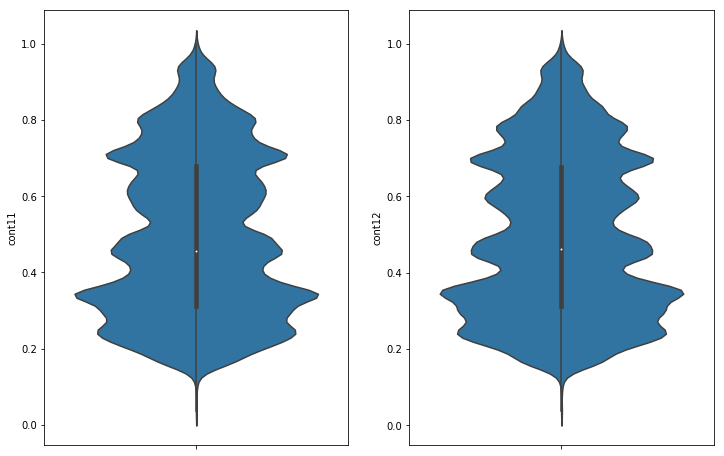

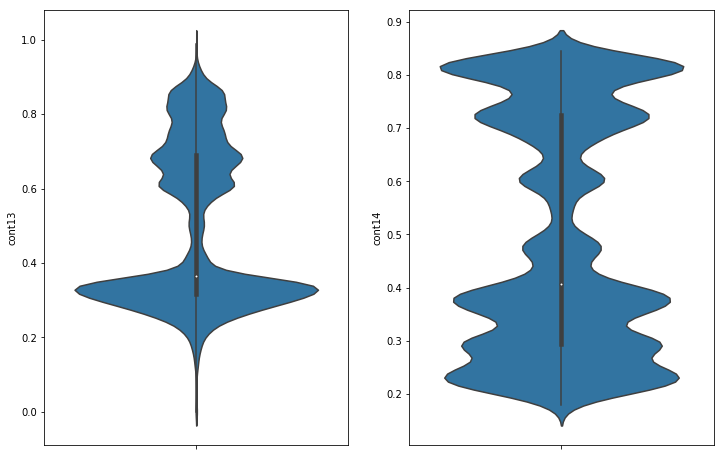

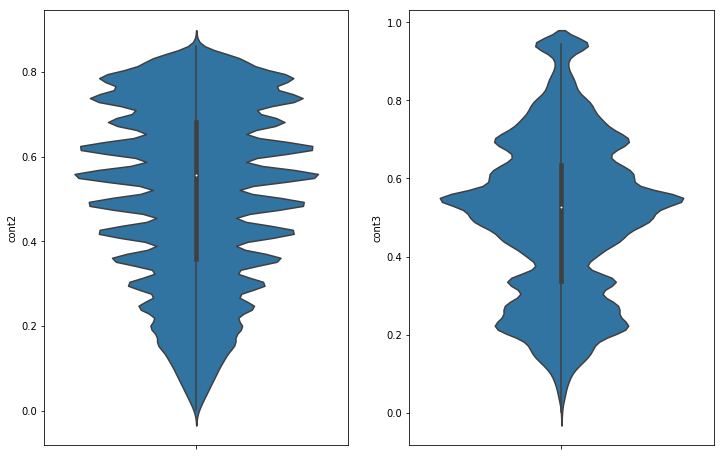

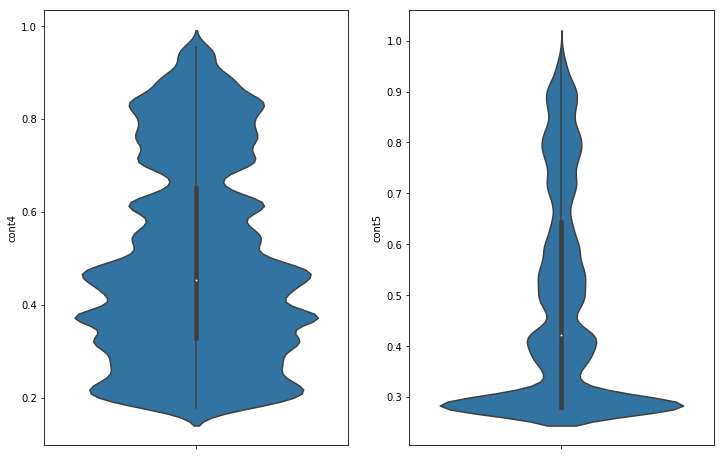

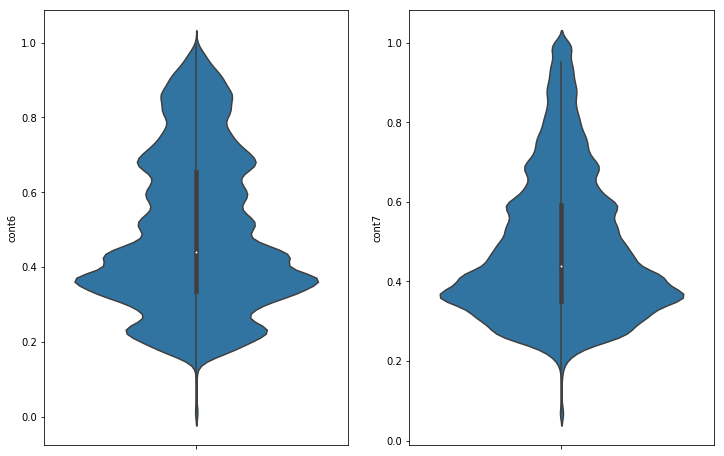

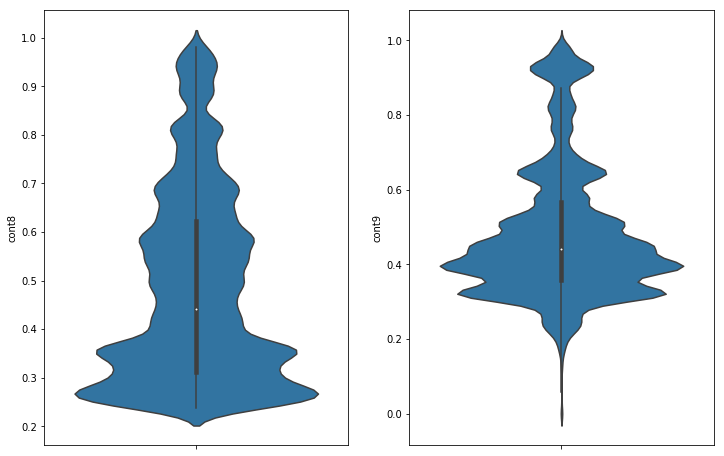

In [11]:
#Plot violin for all con_col in a 7x2 grid
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.violinplot(y=con_cols[i*n_cols+j], data=train, ax=ax[j])

C:\Users\WZHANG\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


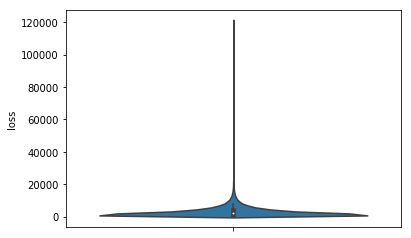

In [12]:
sns.violinplot(data=train,y=train['loss'])
plt.show()

C:\Users\WZHANG\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


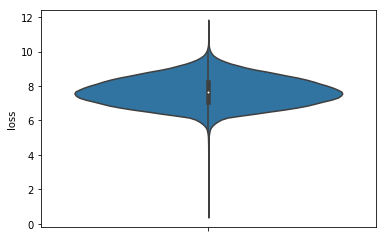

In [13]:
#log1p function applies log(1+x) to all elements of the column
loss = np.log1p(train["loss"])
#visualize the transformed column
sns.violinplot(data=train,y= loss)  
plt.show()

C:\Users\WZHANG\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


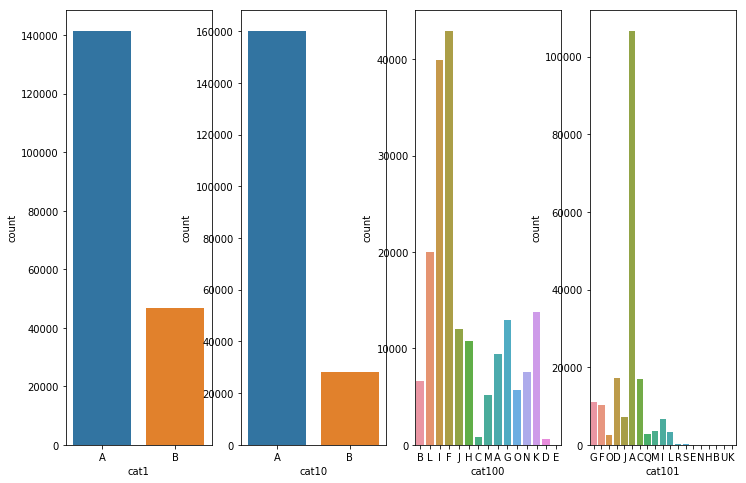

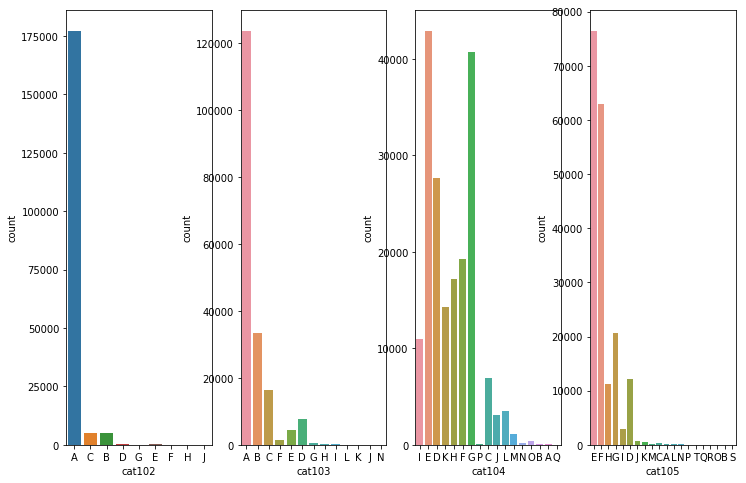

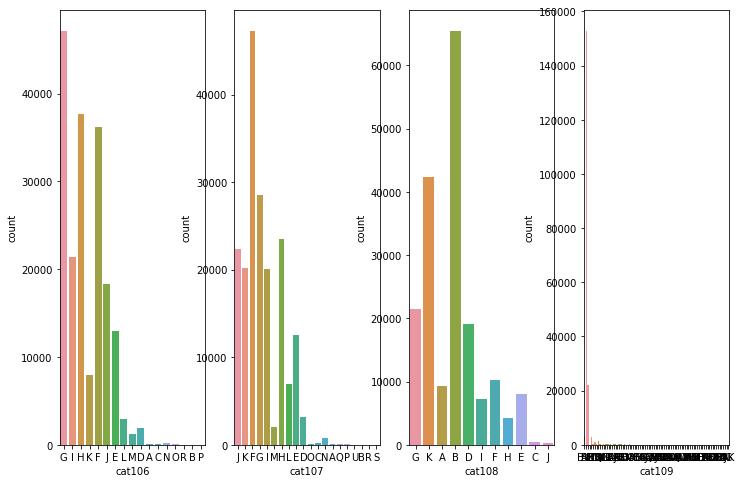

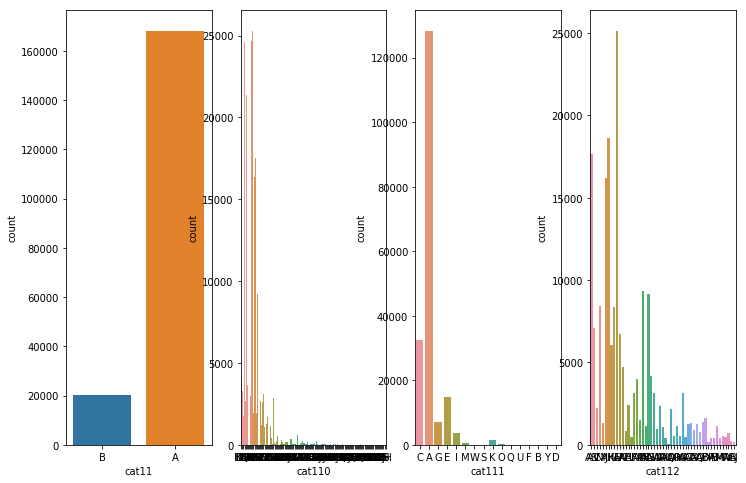

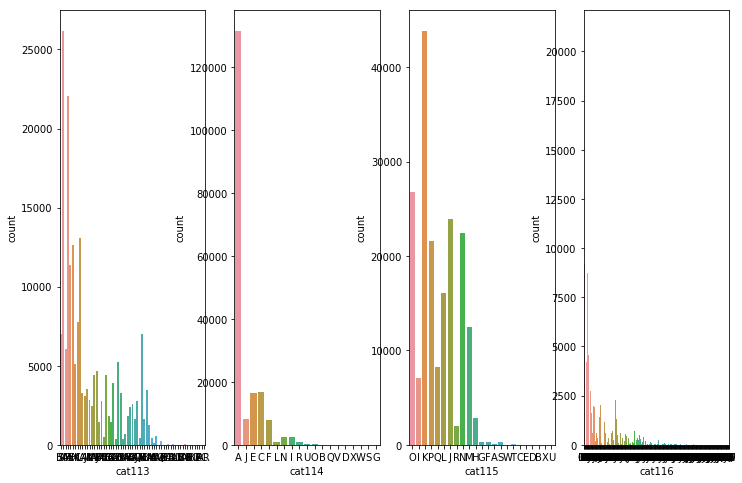

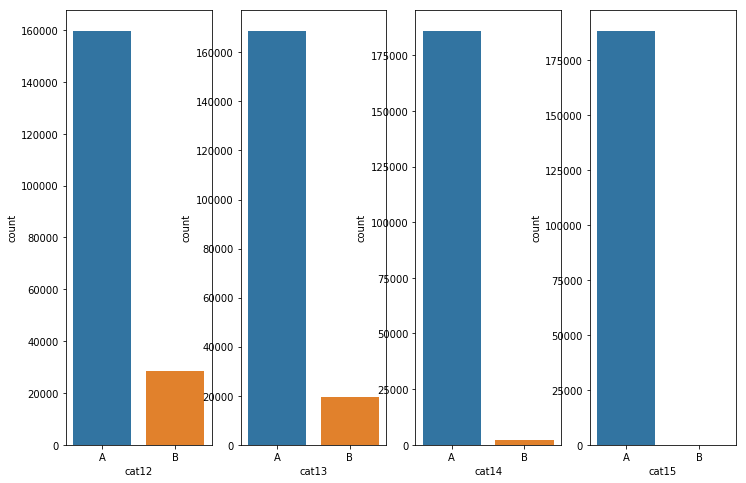

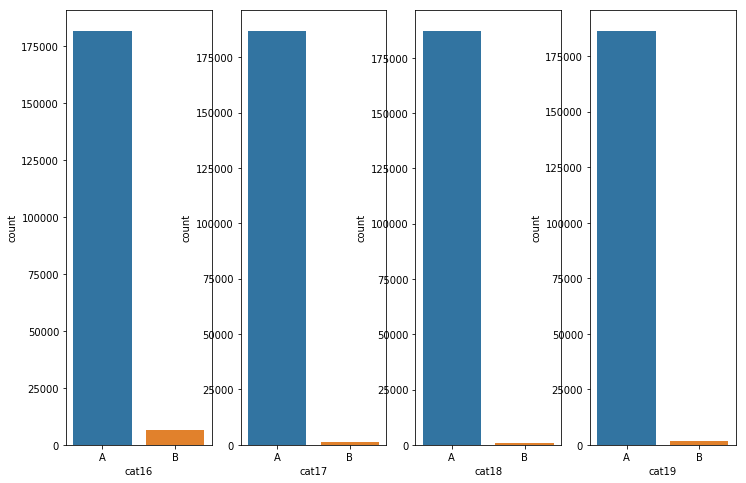

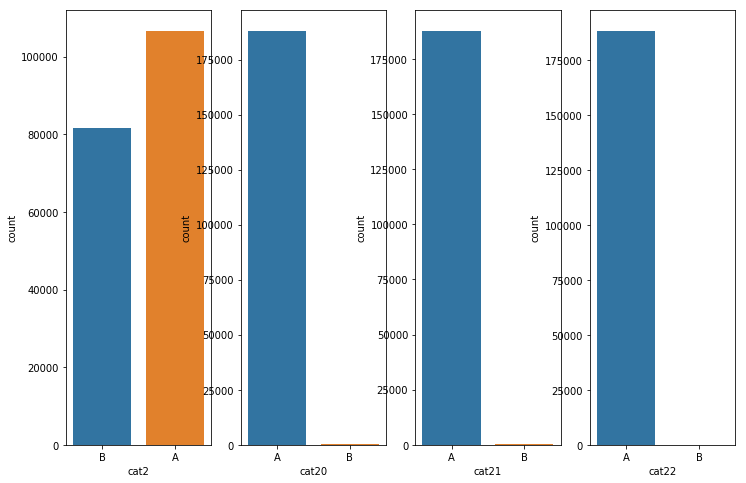

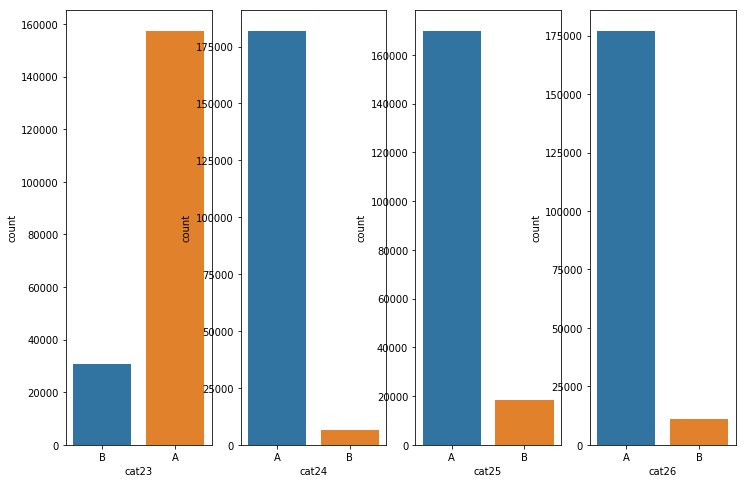

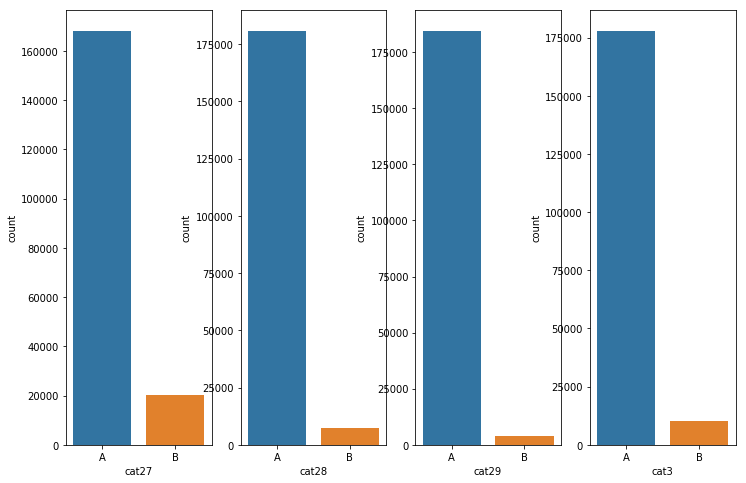

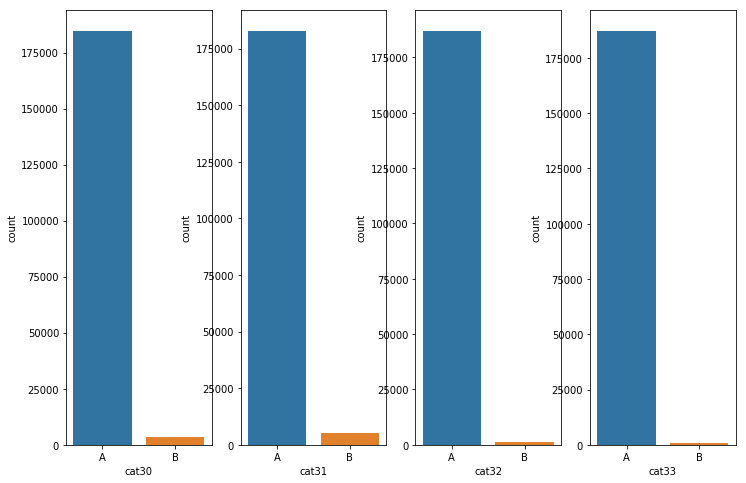

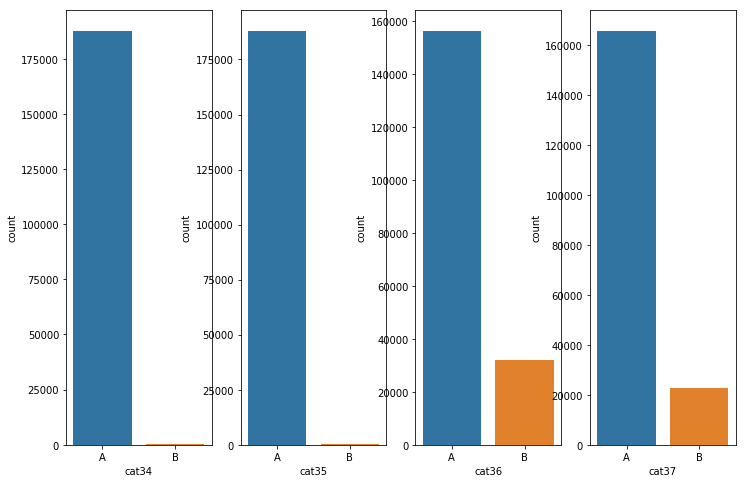

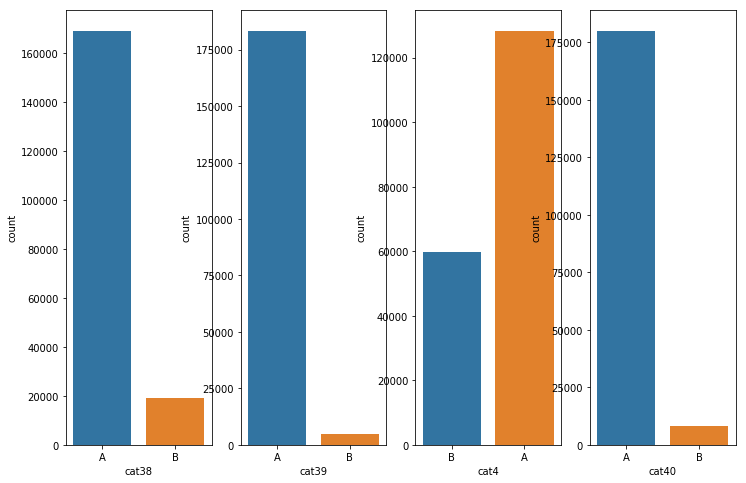

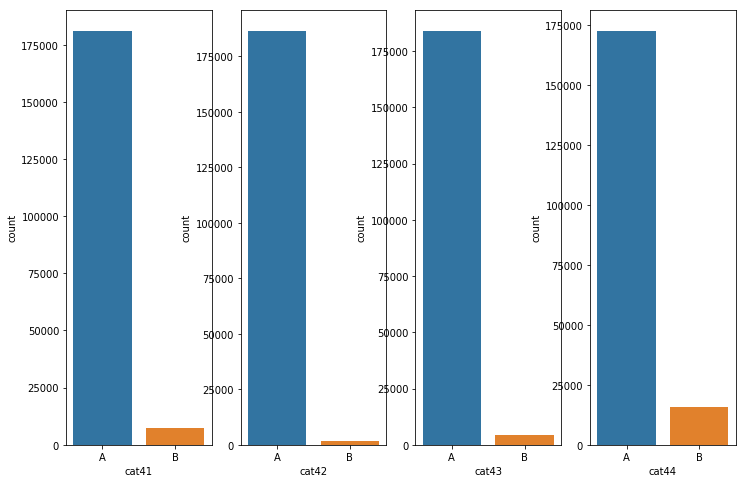

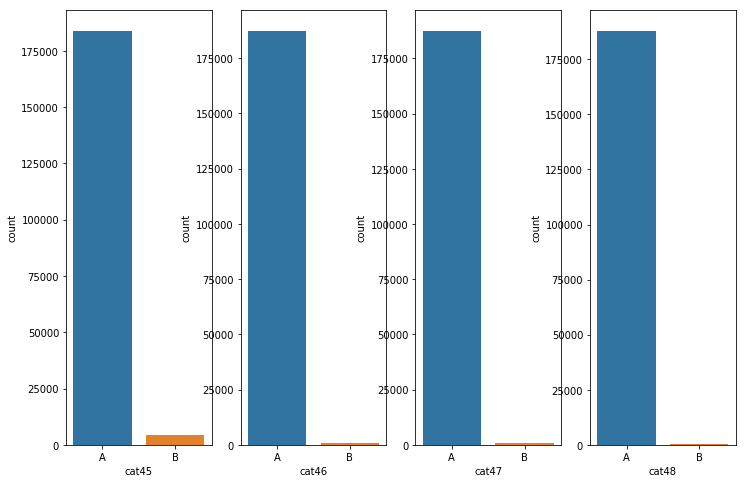

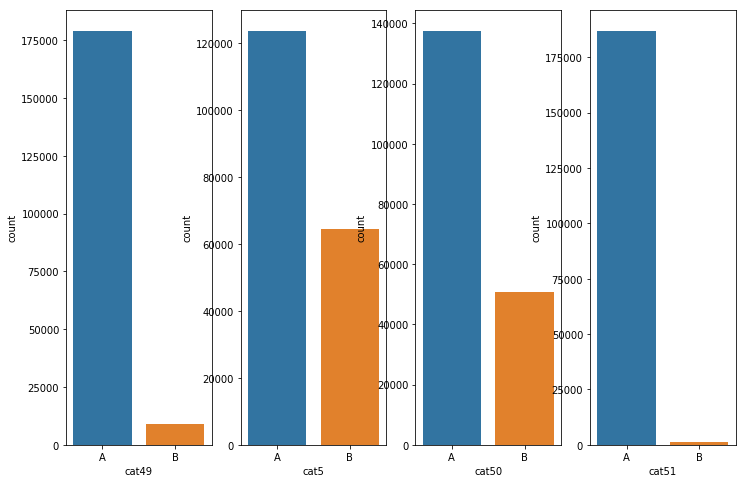

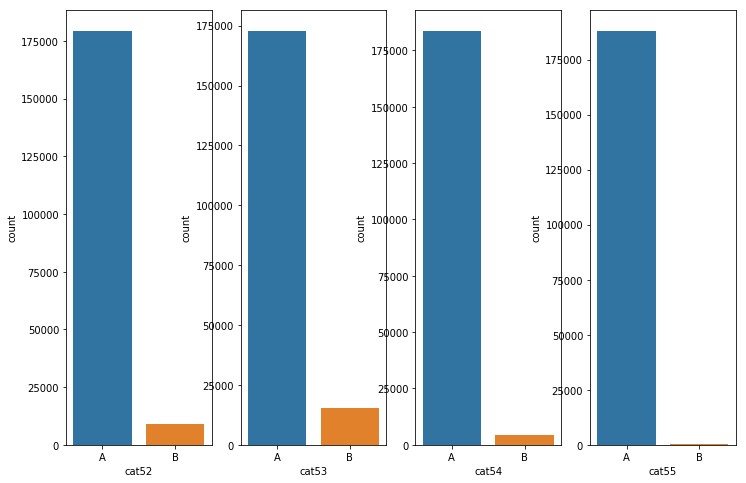

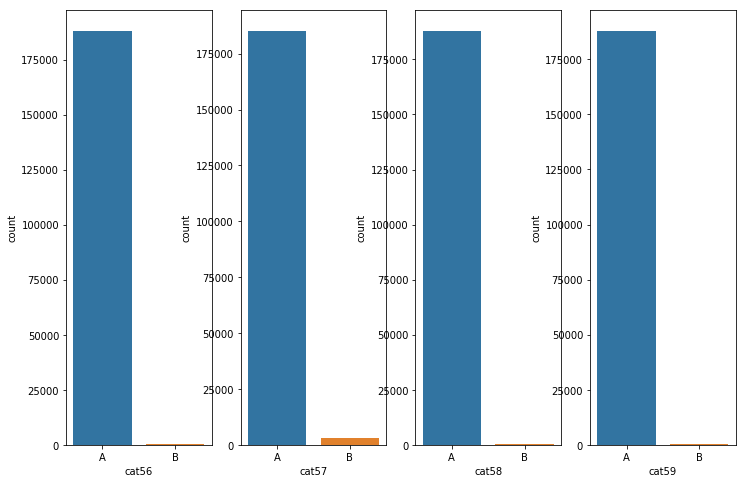

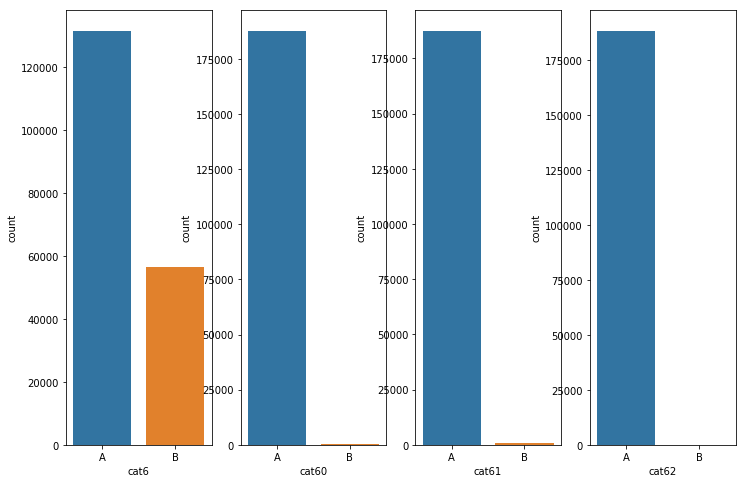

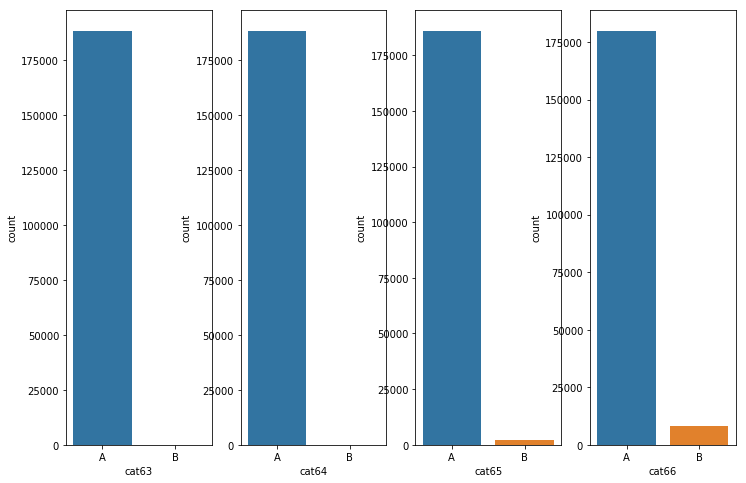

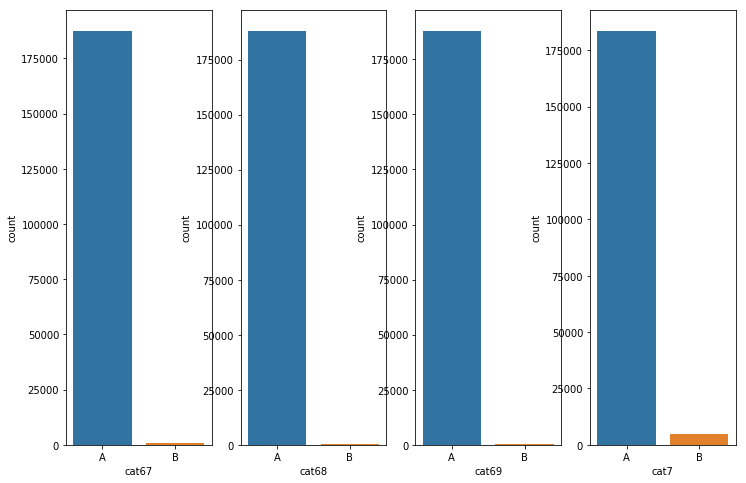

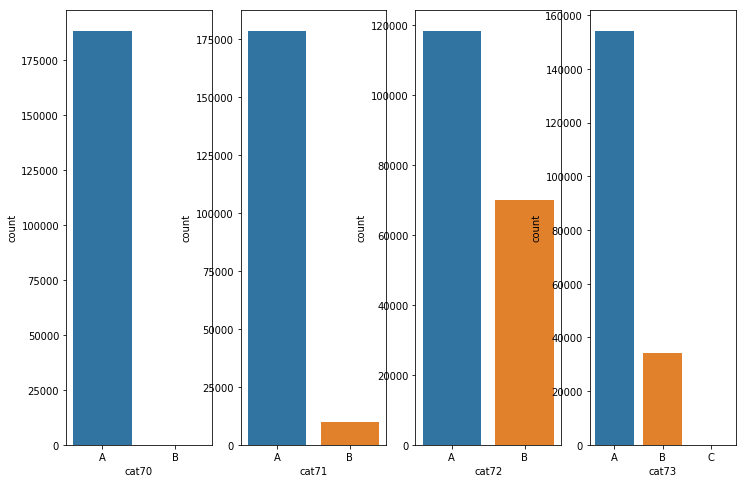

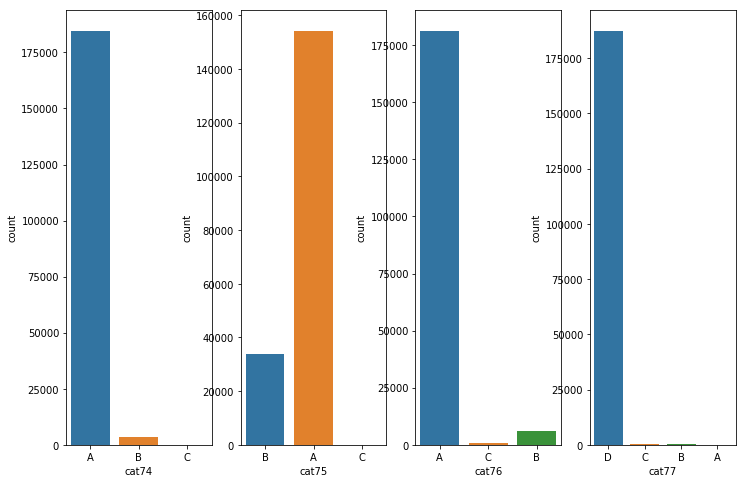

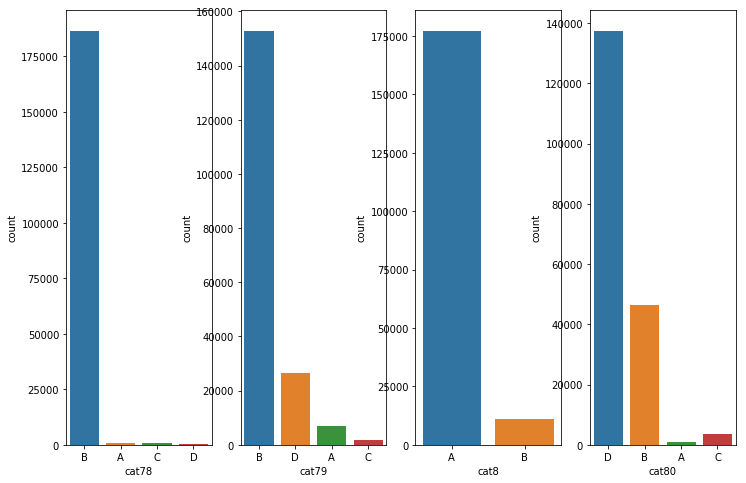

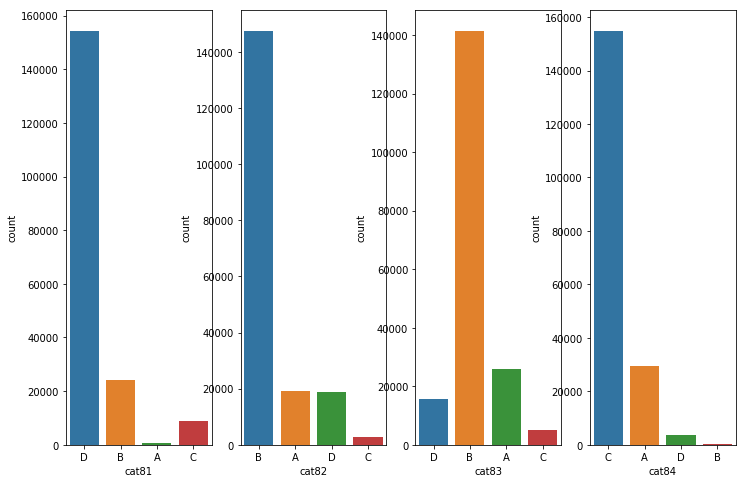

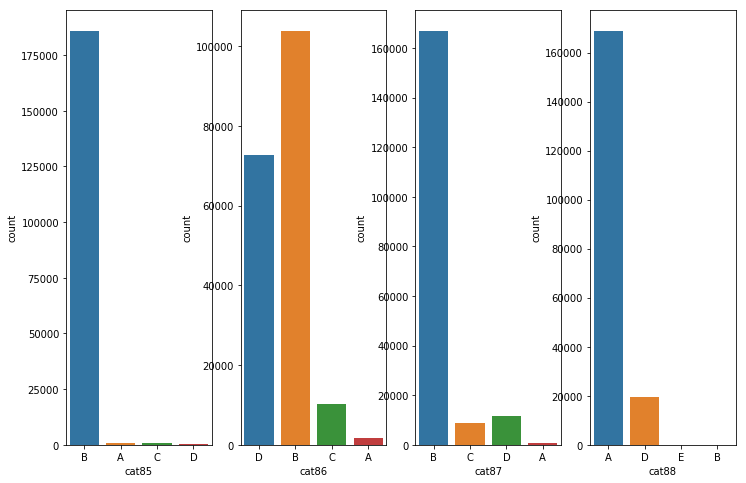

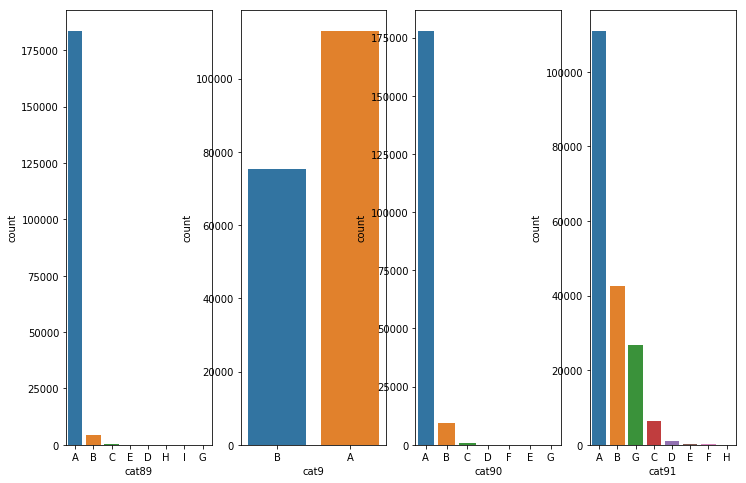

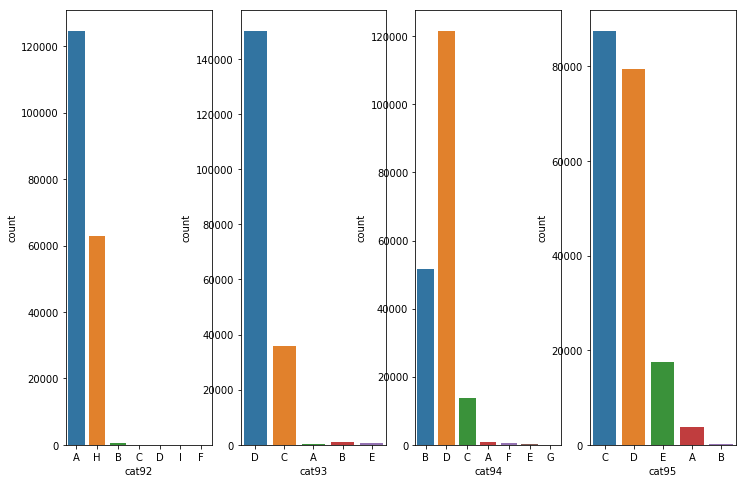

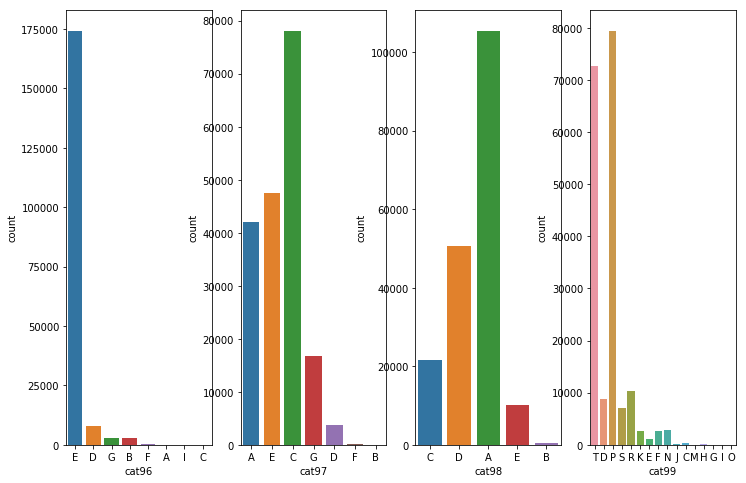

In [14]:
#Plot count plot for all attributes in a 29x4 grid
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.countplot(x=cat_cols[i*n_cols+j], data=train, ax=ax[j])

#cat1 to cat72 have only two labels A and B. In most of the cases, B has very few entries
#cat73 to cat 108 have more than two labels
#cat109 to cat116 have many labels

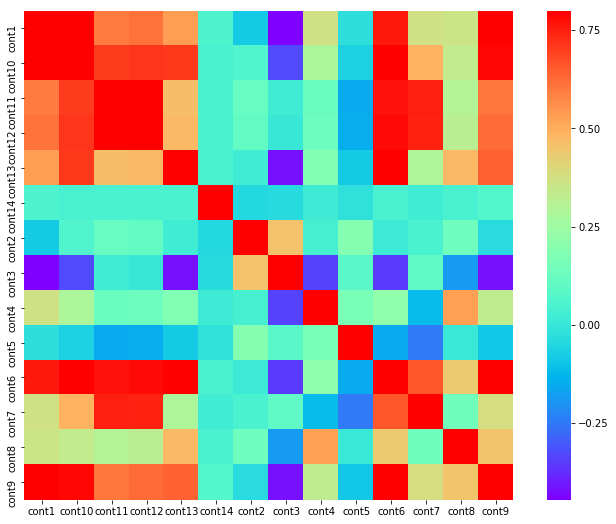

In [15]:
# Correlation
corrmat = train[con_cols].corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True, cmap = 'rainbow')
plt.show()
#Strong correlation is observed between several pairs. 
#This represents an opportunity to reduce the feature set through transformations such as PCA. 

## Categorical features 

In [51]:
LBL = preprocessing.LabelEncoder()
start=time.time()
LE_map=dict()
for cat_col in cat_cols:
    full_data[cat_col] = LBL.fit_transform(full_data[cat_col])
    LE_map[cat_col]=dict(zip(LBL.classes_, LBL.transform(LBL.classes_)))
print ('Label enconding finished in %f seconds' % (time.time()-start))

Label enconding finished in 4.992903 seconds


###  One Hot Encoding (get dummies)

In [52]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(full_data[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

print (full_data_sparse.shape)
print (full_data_sparse)

One-hot-encoding finished in 7.157562 seconds
(313864, 1176)
  (0, 1174)	1.0
  (0, 1156)	1.0
  (0, 1147)	1.0
  (0, 1142)	1.0
  (0, 1135)	1.0
  (0, 1127)	1.0
  (0, 1124)	1.0
  (0, 1112)	1.0
  (0, 1104)	1.0
  (0, 1097)	1.0
  (0, 1096)	1.0
  (0, 1086)	1.0
  (0, 1082)	1.0
  (0, 1079)	1.0
  (0, 1077)	1.0
  (0, 1071)	1.0
  (0, 1068)	1.0
  (0, 1065)	1.0
  (0, 1059)	1.0
  (0, 1057)	1.0
  (0, 1053)	1.0
  (0, 1048)	1.0
  (0, 1045)	1.0
  (0, 1041)	1.0
  (0, 1039)	1.0
  :	:
  (313863, 898)	1.0
  (313863, 896)	1.0
  (313863, 894)	1.0
  (313863, 892)	1.0
  (313863, 890)	1.0
  (313863, 611)	1.0
  (313863, 529)	1.0
  (313863, 499)	1.0
  (313863, 442)	1.0
  (313863, 391)	1.0
  (313863, 368)	1.0
  (313863, 347)	1.0
  (313863, 233)	1.0
  (313863, 149)	1.0
  (313863, 137)	1.0
  (313863, 122)	1.0
  (313863, 107)	1.0
  (313863, 82)	1.0
  (313863, 64)	1.0
  (313863, 47)	1.0
  (313863, 38)	1.0
  (313863, 25)	1.0
  (313863, 11)	1.0
  (313863, 2)	1.0
  (313863, 0)	1.0


## Numeric features

We will apply two preprocessings on numeric features:

1. Apply box-cox transformations for skewed numeric features.

2. Scale numeric features so they will fall in the range between 0 and 1.

Please be advised that these preprocessings are not necessary for tree-based models, e.g. XGBoost. However, linear or linear-based models may benefit from them.

In [53]:
from scipy.stats import skew, boxcox
skewed_cols = full_data[con_cols].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

cont2    -0.101841
cont9    -0.012046
cont3    -0.007023
cont1     0.004049
cont10    0.020122
cont11    0.023397
cont12    0.024871
cont6     0.038833
cont4     0.051627
cont7     0.054710
cont14    0.068549
cont13    0.092823
cont8     0.124111
cont5     0.205682
dtype: float64


In [54]:
skewed_cols = skewed_cols[abs(skewed_cols) > 0.25].index.values
for skewed_col in skewed_cols:
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] + 1)

In [55]:
SSL = preprocessing.StandardScaler()
for con_col in con_cols:
     full_data[con_col] = SSL.fit_transform(full_data[con_col].values.reshape(-1,1))

## Model Building: Xgboost

In [56]:
from scipy import sparse
full_data_sparse = sparse.hstack((full_data_sparse,full_data[con_cols]), format='csr')
print (full_data_sparse.shape)

(313864, 1190)


In [57]:
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200)
ID = full_data.id[:train_size].values


In [58]:
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def log_mae(y,yhat):
    return mean_absolute_error(np.exp(y), np.exp(yhat))

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

In [59]:
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [62]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})

In [ ]:
param_grid = {'objective':[logregobj],
              'learning_rate':[0.02, 0.04, 0.06, 0.08],
              'n_estimators':[1500],
              'max_depth': [9],
              'min_child_weight':[50],
              'subsample': [0.78],
              'colsample_bytree':[0.67],
              'gamma':[0.9],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78 
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78, score=-1135.4126562248493, total=25.3min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.8min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78, score=-1138.3068197249654, total=24.8min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 51.1min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78, score=-1135.787244363727, total=25.2min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 76.8min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78, score=-1133.967796463022, total=24.9min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x000001A20CE39D08>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 102.2min remaining:    0.0s


In [63]:
rgr = xgb.XGBRegressor(seed = 1234, 
                       learning_rate = 0.01, # smaller, better results, more time
                       n_estimators = 1500, # Number of boosted trees to fit.
                       max_depth=9, # the maximum depth of a tree
                       min_child_weight=50,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

[23:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[23:09:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[23:09:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[23:09:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[23:09:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[23:09:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[23:09:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.67, gamma=0.9, learning_rate=0.01,
       max_delta_step=0, max_depth=9, min_child_weight=50, missing=None,
       n_estimators=1500, n_jobs=1, nthread=-1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1234, silent=False, subsample=0.78)

In [65]:
pred_y = np.exp(rgr.predict(test_x)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("Desktop/DAL/sub.csv", index=False)
print ("Submission created.")

Submission created.


In [72]:
result = pd.read_csv('Desktop/DAL/sub.csv', header=0)
result.head(10)

,id,loss
0,4,1484.9498
1,6,1897.0769
2,9,8173.1016
3,12,5785.0190
4,15,807.2648
5,17,2274.4612
6,21,2294.7890
7,28,863.4824
8,32,2352.3613
9,43,3117.2380
